Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Custom Raster Datasets

In this tutorial, we demonstrate how to create a custom `RasterDataset` for our own data. We will use the [xView3](https://iuu.xview.us/) tiny dataset as an example.

# Setup

In [ ]:
%pip install torchgeo

# Imports

In [1]:
from pathlib import Path
from typing import Callable, Dict, Optional

import matplotlib.pyplot as plt
import torch
from rasterio.crs import CRS
from torch import Tensor
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, stack_samples
from torchgeo.samplers import RandomGeoSampler


# Custom RasterDataset

## Unzipping the sample xView3 data from the tests folder

In [2]:
from torchgeo.datasets.utils import extract_archive

data_root = Path('../../tests/data/xview3/')
extract_archive(str(data_root / 'sample_data.tar.gz'))

Now we have the xView3 tiny dataset downloaded and unzipped in our local directory. Note that all the test GeoTIFFs are comprised entirely of zeros. Any plotted image will appear to be entirely uniform.

    xview3
    ├── 05bc615a9b0aaaaaa
    │   ├── bathymetry.tif
    │   ├── owiMask.tif
    │   ├── owiWindDirection.tif
    │   ├── owiWindQuality.tif
    │   ├── owiWindSpeed.tif
    │   ├── VH_dB.tif
    │   └── VV_dB.tif

We would like to create a custom Dataset class based off of RasterDataset for this xView3 data. This will let us use `torchgeo` features such as: random sampling, merging other layers, fusing multiple datasets with `UnionDataset` and `IntersectionDataset`, and more. To do this, we can simply subclass `RasterDataset` and define a `filename_glob` property to select which files in a root directory will be included in the dataset. For example:

In [3]:
class XView3Polarizations(RasterDataset):
    '''
    Load xView3 polarization data that ends in *_dB.tif
    '''

    filename_glob = "*_dB.tif"

    def __init__(
        self,
        root: Path = None,
        crs: Optional[CRS] = None,
        res: Optional[float] = None,
        transforms: Optional[Callable[[Dict[str, Tensor]], Dict[str, Tensor]]] = None,
        cache: bool = True
    ) -> None:
        self.root = root

        super().__init__(root, crs, res, transforms, cache)

torch.Size([1, 1, 102, 102])
torch.Size([1, 1, 102, 102])
torch.Size([1, 1, 102, 102])
torch.Size([1, 1, 102, 102])
torch.Size([1, 1, 102, 102])


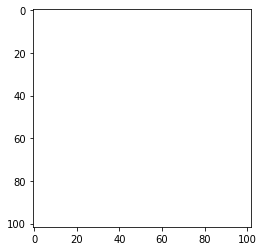

In [4]:
ds = XView3Polarizations(data_root)
sampler = RandomGeoSampler(ds, size=1024, length=5)
dl = DataLoader(ds, sampler=sampler, collate_fn=stack_samples)

for sample in dl:
    image = sample['image']
    print(image.shape)
    image = torch.squeeze(image)
    plt.imshow(image, cmap='bone', vmin=-35, vmax=-5)